# Assignment 1 - Image Deblurring

Name: Nalet Meinen<br>
Matriculation number: 13-463-955

Disclaimer! There are some mistakes in the gradient. I did not found the mistake I've made when I copied it from the provided solution.

In [1]:
import numpy as np
import scipy
from scipy import signal
from scipy.sparse import *
from scipy.sparse.linalg import *
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

from hessian_matrix import hessian_matrix

## Test Image

You can use the following function to create a synthetic image:



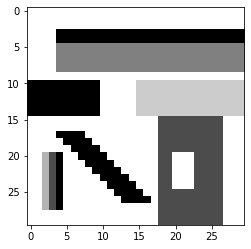

In [2]:
def create_random_binary_img_1():
    
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(np.float)

    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [3]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.5 -2.   0.5 -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.5  0.   0.5 -2.   0.   0.   0. ]
 [-2.   0.5  0.   6.5 -2.   0.  -2.   0.   0. ]
 [ 0.  -2.   0.5 -2.   9.  -2.   0.5 -2.   0. ]
 [ 0.   0.  -2.   0.  -2.   6.5  0.   0.5 -2. ]
 [ 0.   0.   0.  -2.   0.5  0.   4.5 -2.   0. ]
 [ 0.   0.   0.   0.  -2.   0.5 -2.   6.5 -2. ]
 [ 0.   0.   0.   0.   0.  -2.   0.  -2.   4. ]]


## Implementation

In [4]:
def loss_data_term(g, u):
    """
    gives the norm 2 loss between g and u
    """
    if g.shape == u.shape:
        g = np.delete(g.copy(), -1, axis=1)
        g = np.delete(g, -1, axis=0)
    return np.linalg.norm(g[:,:] - 0.5 * u[1:,1:] - 0.5 * u[0:-1,1:], 2) ** 2

def ssd(u, g):
    """
    Gives us back the SSD
    """
    return np.sum((u-g) ** 2)

def data_term_f(g, u):
    """
    Returns the data term for a given kernel
    """
    delta_u = np.zeros(u.shape)

    delta_u[1:-1,1:] = u[1:-1,1:] + 0.5 * u[:-2,1:] + 0.5 * u[2:,1:] - g[:-1,:] - g[1:,:]
    delta_u[:,0] = 0
    delta_u[0,1:] = 0.5 * u[0,1:] + 0.5 * u[1,1:] - g[0,:]
    delta_u[-1,1:] = 0.5 * u[-2,1:] + 0.5 * u[-1,1:] - g[-1,:]

    return delta_u
    
def reg_term_f(u, reg_term_method):
    """
    returns the reg term for the selected method
    """
    reg_term = np.zeros(u.shape)
    
    if reg_term_method == 'anisotropic':
        reg_term_1 = reg_term.copy()
        reg_term_1[0,:] = -np.sign(u[1,:] - u[0,:])
        reg_term_1[1:-1,:] = -np.sign(u[2:,:] - u[1:-1,:]) + np.sign(u[0:-2,:] - u[1:-1,:])
        reg_term_1[-1,:] = np.sign(u[-1,:] - u[-2,:])

        reg_term_2 = reg_term.copy()
        reg_term_2[:,0] = -np.sign(u[:,1] - u[:,1])
        reg_term_2[:,1:-1] = -np.sign(u[:,2:] - u[:,1:-1]) + np.sign(u[:,0:-2] - u[:,1:-1])
        reg_term_2[:,-1] = np.sign(u[:,-1] - u[:,-2])

        reg_term = reg_term_1 + reg_term_2
            
    if reg_term_method == 'gauss':
        reg_term_1 = reg_term.copy()
        reg_term_1[1:-2,1:-2] = 8 * u[1:-2,1:-2] - 2 * u[2:-1,1:-2] - 2 * u[1:-2,2:-1] - 2 * u[0:-3,1:-2] - 2 * u[1:-2,0:-3]
        reg_term_1[0,0] = 4 * u[0,0] - 2 * u[1,0] - 2 * u[0,1]
        reg_term_1[1:-2,0] = 6 * u[1:-2,0] - 2 * u[2:-1,0] - 2 * u[1:-2,1] - 2 * u[0:-3,0]
        reg_term_1[:-2,-1] = 2 * u[:-2,-1] - 2 * u[:-2,-2]
        reg_term_1[-1,0:-2] = 2 * u[-1,0:-2] - 2 * u[-2,0:-2]
        reg_term_1[0,1:-2] = 6 * u[0,1:-2] - 2 * u[1,1:-2] - 2 * u[0,2:-1] - 2 * u[0,0:-3]
        reg_term_1[-1,-1] = 0

        reg_term_2 = reg_term.copy()
        reg_term_2[-1,1:-2] = 4 * u[-1,1:-2] - 2 * u[-1,0:-3] - 2 * u[-1,2:-1]
        reg_term_2[-1,0] = 2 * u[-1,0] - 2 * u[-1,1]
        reg_term_2[-1,-1] = 2 * u[-1,-1] - 2 * u[-1,-2]

        reg_term_3 = reg_term.copy()
        reg_term_3[1:-2,-1] = 4 * u[1:-2,-1] - 2 * u[0:-3,-1] - 2 * u[2:-1,-1]
        reg_term_3[0,-1] = 2 * u[0,-1] - 2 * u[1,-1]
        reg_term_3[-1,-1] = 2 * u[-1,-1] - 2 * u[-2,-1]

        reg_term = reg_term_1 + reg_term_2 + reg_term_3
        
    return reg_term
    

In [5]:
def GD(g, reg_lambda = 0.01, epsilon = 0.01, iter = 1000, reg_term_method = 'anisotropic'):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    
    u = np.zeros((g.shape[0]+1,g.shape[1]+1))
    u[:-1,:-1] = g.copy()
    
    losses = []
    
    
    # This loop gets for each iteration the data and reg term
    # and updates it. episilon corresponds to the step size
    for _ in range(iter):
        delta_u = data_term_f(g, u)
        reg_term = reg_term_f(u, reg_term_method)
        
        u -= epsilon * delta_u + reg_lambda * reg_term
        losses.append(loss_data_term(g, u))
    
    return u, losses

In [6]:
def LGS(g, reg_lambda):
    """
    Linearalized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    u = np.zeros((g.shape[0]+1,g.shape[1]+1))
    u[:-1,:-1] = g.copy()
    
    losses = []
    
    for _ in tqdm(range(22)):
        
        # We get the reg and data term and obtain the hessian with it.
        data_term = data_term_f(g, u.reshape((g.shape[0]+1,g.shape[1]+1)))
        reg_term = np.sum(reg_lambda * reg_term_f(u.reshape((g.shape[0]+1,g.shape[1]+1)), 'gauss'))

        he = hessian_matrix(data_term, reg_term, k)

        u = csr_matrix(u.flatten())
        data_term = csr_matrix(data_term.flatten())
        
        # here we prepare the terms for the Gauss-Seidel method
        A = he
        D = csr_matrix(A.shape)
        D.setdiag(A.diagonal())

        L = tril(A)
        U = triu(A, k=1) # be careful about the overlapping part
        
        b = u * he - data_term
        
        b = b.T - U * u.T        

        # Here the Gauss-Seidel algorithm should be instead of sp solve.
        # As mentioned in the lecture, one could use any solver when the 
        # problem takes the form Ax=b. A first attempt was made with the 
        # Gauss-Sidel algorithm form the tutorials. But a 900x900 array took
        # too long (ca. 30 min). 
        #ut_1 = spsolve(L, b)
        
        # Nevermind! found the gift in the tutorials.
        
        def Gauss_Seidel(A, b):
            """
            Here we use one iteration to shield the variables
            """
            Nit = 1
            N = b.shape[0]
            A = A.toarray()
            b = b.toarray()
            du = np.zeros(N)
            err_GS = np.zeros(Nit)
            checked = False
            for tt in range(Nit):
                dunew = np.zeros(N)
                for i in range(N):
                    dunew[i] = (b[i] - np.sum(A[i, np.concatenate((np.arange(i), np.arange(i+1, N)))] @ np.concatenate((dunew[:i], du[i+1:N]))))/A[i,i]
                du = dunew  
                if np.mean(np.abs(du))<1e-6:
                    break
            return du
        ut_1 = Gauss_Seidel(A, b)

        ut_1.reshape((1,u.shape[1]))

        u = ut_1
        losses.append(loss_data_term(g, u.reshape((g.shape[0]+1,g.shape[1]+1))))

    return u.reshape((g.shape[0]+1,g.shape[1]+1)), losses

In [7]:
def LSOR(g, reg_lambda, w):
    """
    Linearized SOR Algorithm
    g: grayscale blyrry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    """
    u = np.zeros((g.shape[0]+1,g.shape[1]+1))
    u[:-1,:-1] = g.copy()
    
    losses = []
    
    for _ in tqdm(range(22)):
        
        # We get the reg and data term and obtain the hessian with it.
        data_term = data_term_f(g, u.reshape((g.shape[0]+1,g.shape[1]+1)))
        reg_term = np.sum(reg_lambda * reg_term_f(u.reshape((g.shape[0]+1,g.shape[1]+1)), 'gauss'))

        he = hessian_matrix(data_term, reg_term, k)

        u = csr_matrix(u.flatten())
        data_term = csr_matrix(data_term.flatten())

        # here we prepare the terms for the relaxation method
        A = he
        D = csr_matrix(A.shape)
        D.setdiag(A.diagonal())

        L = tril(A, k=-1)
        U = triu(A, k=1)

        b = u * he - data_term
        
        A = D + w * L

        b = w * b.T - (w * U + (w - 1) * D) * u.T

        # Here the Gauss-Seidel algorithm should be instead of sp solve.
        # As mentioned in the lecture, one could use any solver when the 
        # problem takes the form Ax=b. A first attempt was made with the 
        # Gauss-Sidel algorithm form the tutorials. But a 900x900 array took
        # too long (ca. 30 min). 
        #ut_1 = spsolve(A, b)
        
        # Nevermind! found the gift in the tutorials.
        
        def SOR(A, b, w):
            """
            Here we use one iteration to shield the variables
            """
            Nit = 1
            N = b.shape[0]
            A = A.toarray()
            b = b.toarray()
            du = np.zeros(N)
            err_SOR = np.zeros(Nit)
            checked = False
            for tt in range(Nit):
                dunew = np.zeros(N)
                for i in range(N):
                    dunew[i] = (1-w) * du[i] + w * (b[i] - np.sum(A[i, np.concatenate((np.arange(i), np.arange(i+1, N)))] @ np.concatenate((dunew[:i], du[i+1:]))))/A[i,i]
                du = dunew
            
            return du

        ut_1 = SOR(A, b, w)

        ut_1.reshape((1,u.shape[1]))

        u = ut_1
        losses.append(loss_data_term(g, u.reshape((g.shape[0]+1,g.shape[1]+1))))

    return u.reshape((g.shape[0]+1,g.shape[1]+1)), losses

### Parameters

In [8]:
reg_lambda = 0.001 # lambda regularization parameter. you need to play with this 
# k matrix. Look below how to choose it 
k = 1

$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$



### Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [9]:
img_org = sample_image = create_random_binary_img_1()

# TODO: define the kernel matrix here
kernel = np.array([[0.5, 0], [0.5, 0]]);

# TODO: blur this image
img_blurred = scipy.signal.convolve2d(sample_image, kernel, 'valid')

## GRADIENT DESCENT


reg_lambda = 0.0, epsilon = 0.01, iter = 1000 reg_term_method = 'none':


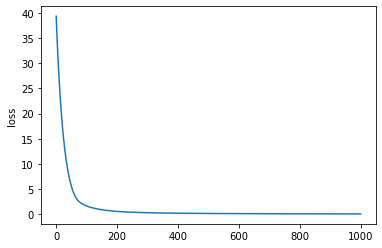

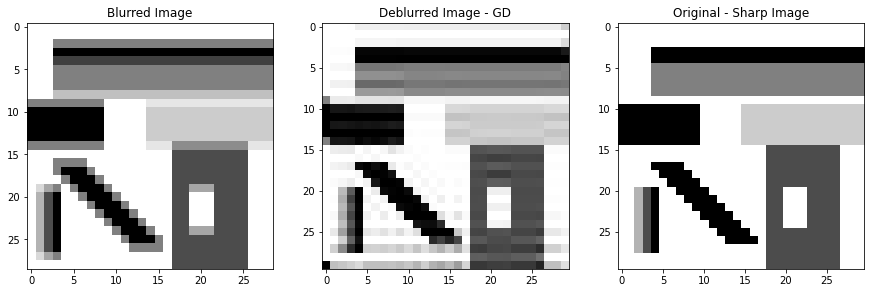

For lambda 0.00000	 
k_type 1
Loss Data Term = 1246.3797352294657
Sum of Squared Distance: deblurred vs. original = 5.225322362900554

reg_lambda = 0.001, epsilon = 0.001, iter = 1000 reg_term_method = 'anisotropic':


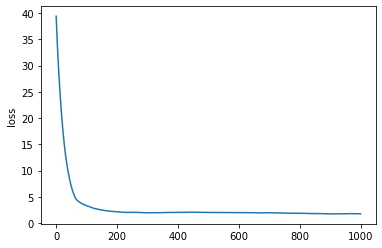

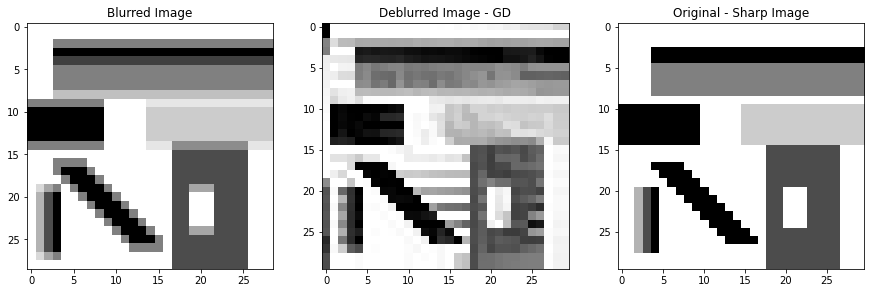

For lambda 0.00100	 
k_type 1
Loss Data Term = 2976.170584375175
Sum of Squared Distance: deblurred vs. original = 25.20615010389927

reg_lambda = 0.001, epsilon = 0.001, iter = 1000 reg_term_method = 'gauss':


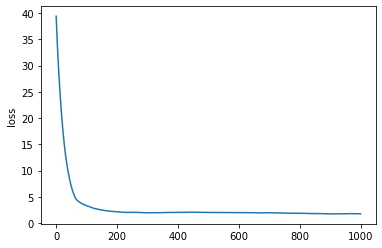

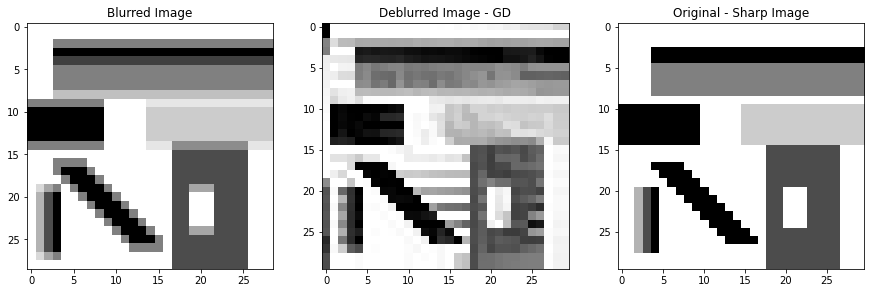

For lambda 0.00100	 
k_type 1
Loss Data Term = 2976.170584375175
Sum of Squared Distance: deblurred vs. original = 25.20615010389927


In [10]:
def GD_run(reg_lambda, epsilon, iter, reg_term_method):
    # run gradient descent algorithm
    img_deblurred_gd, losses = GD(img_blurred, reg_lambda)

    # for visualization purpose 
    img_deblurred_gd = np.clip(img_deblurred_gd, 0, 1)
    
    print(f"\nreg_lambda = {reg_lambda}, epsilon = {epsilon}, iter = {iter} reg_term_method = '{reg_term_method}':")
    
    plt.plot(losses)
    plt.ylabel('loss')
    plt.show()

    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(img_blurred, cmap='gray')
    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(img_deblurred_gd, cmap='gray')
    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(img_org, cmap='gray')

    ax1.set_title("Blurred Image")
    ax2.set_title("Deblurred Image - GD")
    ax3.set_title("Original - Sharp Image")
    plt.show()

    print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")

    # TODO: print the loss
    print(f"Loss Data Term = {np.sum(losses)}")

    # TODO: print the error
    print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_gd, img_org)}")  
    
GD_run(reg_lambda = 0.000, epsilon = 0.0100, iter = 1000, reg_term_method = 'none')
GD_run(reg_lambda = 0.001, epsilon = 0.0010, iter = 1000, reg_term_method = 'anisotropic')
GD_run(reg_lambda = 0.001, epsilon = 0.0010, iter = 1000, reg_term_method = 'gauss')

## SOR

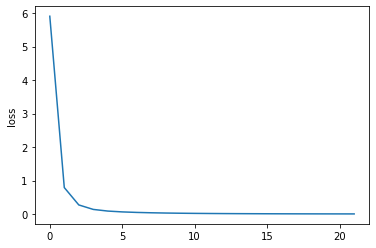

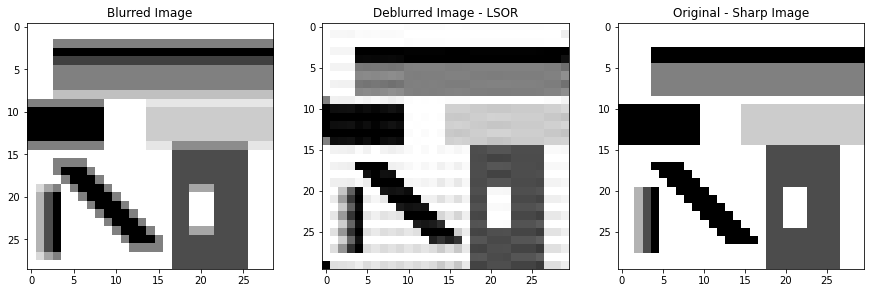

For lambda 0.00010
Loss Data Term = 7.545809602087149
Sum of Squared Distance: deblurred vs. original = 3.3987296981716106


In [11]:
w = 1.0 #play with this
reg_lambda = 0.0001
# run LSOR algorithm
img_deblurred_sor, losses = LSOR(img_blurred, reg_lambda, w)
# for visualization purpose 
img_deblurred_sor = np.clip(img_deblurred_sor, 0, 1)

plt.plot(losses)
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org,cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = {np.sum(losses)}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_sor, img_org)}")  

## GAUSS - SEIDEL

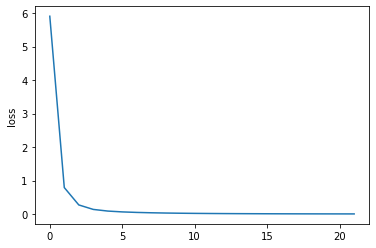

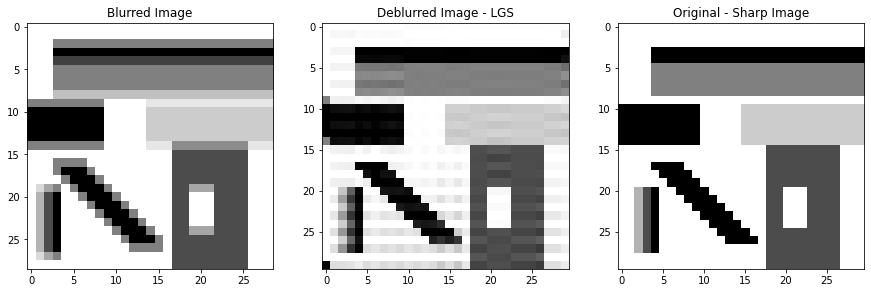

For lambda 0.00010
Loss Data Term = 7.545809602087149
Sum of Squared Distance: deblurred vs. original = 3.3987296981716106


In [12]:
nb_iter = 1
reg_lambda = 0.0001
# run LGS algorithm
img_deblurred_gs, losses = LGS(img_blurred, reg_lambda)
# for visualization purpose 
img_deblurred_gs = np.clip(img_deblurred_gs, 0, 1)

plt.plot(losses)
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = {np.sum(losses)}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_gs, img_org)}")  

## Theory questions

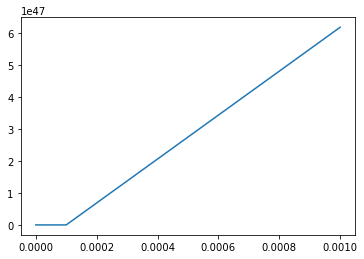

lambda: 1e-100


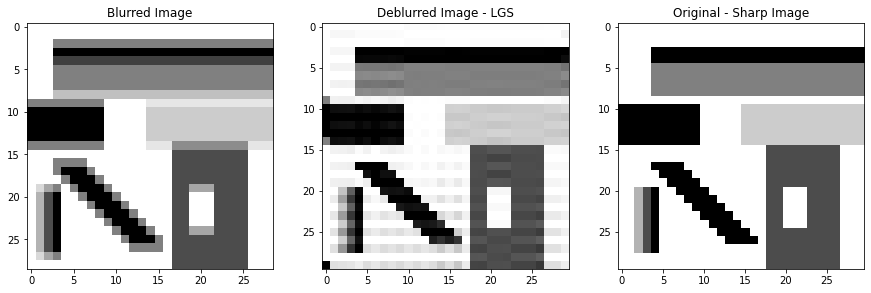

Sum of Squared Distance: deblurred vs. original = 3.276606696083878
lambda: 1e-10


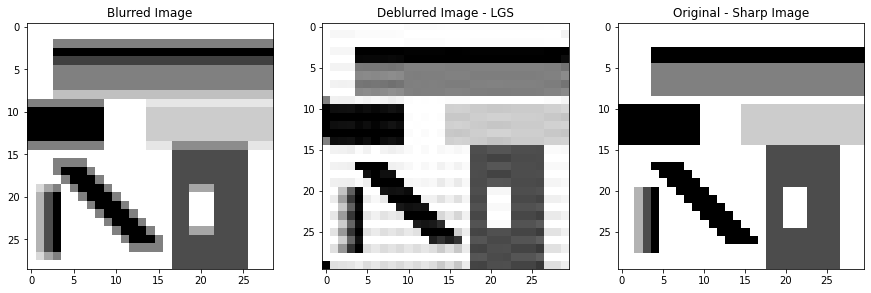

Sum of Squared Distance: deblurred vs. original = 3.276606794709555
lambda: 0.0001


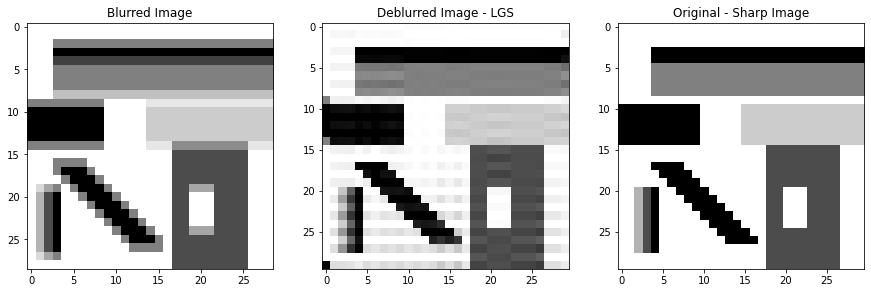

Sum of Squared Distance: deblurred vs. original = 3.3987296981716106
lambda: 0.001


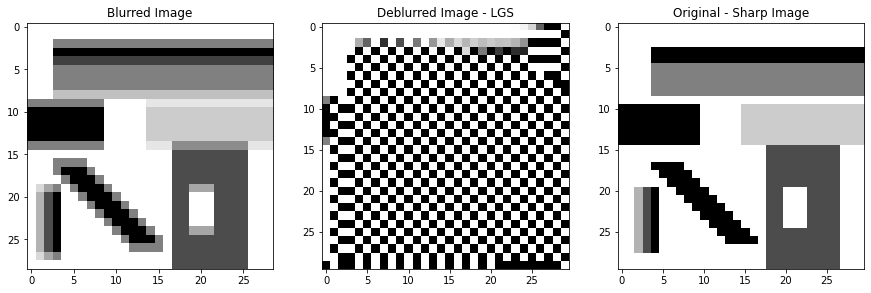

Sum of Squared Distance: deblurred vs. original = 325.8074372780436


In [13]:
from IPython.display import clear_output

reg_lambda_range = [1e-100, 1e-10, 1e-4, 1e-3]

_results_lambda_ssd = []
for _lambda in tqdm(reg_lambda_range):
    img_deblurred_gs, losses = LGS(img_blurred, _lambda)
    _results_lambda_ssd.append(ssd(img_deblurred_gs, img_org))

clear_output(wait=True)
plt.plot(reg_lambda_range, _results_lambda_ssd)
plt.show()

def test_lambda(_lambda_):
    print(f"lambda: {_lambda_}")
    img_deblurred_gs, losses = LGS(img_blurred, _lambda_)
    # for visualization purpose 
    img_deblurred_gs = np.clip(img_deblurred_gs, 0, 1)

    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(img_blurred, cmap='gray')
    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(img_deblurred_gs, cmap='gray')
    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(img_org, cmap='gray')

    ax1.set_title("Blurred Image")
    ax2.set_title("Deblurred Image - LGS")
    ax3.set_title("Original - Sharp Image")
    plt.show()
    print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_gs, img_org)}")  
    
test_lambda(1e-100)
test_lambda(1e-10)
test_lambda(1e-4)
test_lambda(1e-3)

The lambda term stears the regularization parameter. Herea example from wikipedia: <br> 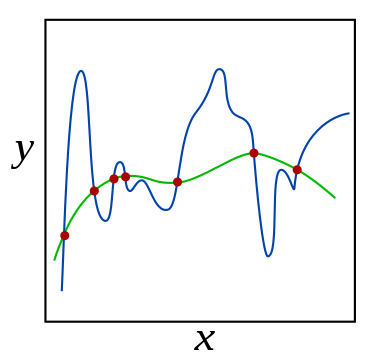 <br>
When the regularization term would be too high, our model would be too simple and would not be able to represent the real world. If it is too low the noise of the image would also be captured. The regularization term helps to cut out noise.

In our case we don't have any noise in our artificial image (in our case we see a lot of artifacts from a faulty gradient). So lambda has not a large influence in making the image better. The data term captures the image well enough and dont need any regularization. Also in the examples provided, we see that we're messing with the solver, as it is not able to find any good solution for a good representation of the image.

Going back to our image. High lamda would lead to an overfit and big lambda to an underfit.